<a href="https://colab.research.google.com/github/Abimbola-ai/Blood-Spectorscopy/blob/main/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Research Links:
* https://www.researchgate.net/publication/258716133_Miniature_Near-Infrared_NIR_Spectrometer_Engine_For_Handheld_Applications

* https://journals.sagepub.com/doi/abs/10.1255/jnirs.1084

In [1]:
import os
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
%matplotlib inline
import re
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, StratifiedShuffleSplit, GroupKFold
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings


In [2]:
#load Datasets
maindir = "/Users/Abimbola/Documents/MSc Computer Science/Semester 2/Computer science project/Blood-Spectorscopy/Data" # Directory with your files
train = maindir+"/Updated_Train.csv"
test =  maindir+"/Updated_Test.csv"
ss =  maindir+"/Updated_Sample_Submission.csv"
test_trimmed = maindir+"/Updated_Test_trimmed.csv"
hdl_add_lowstd = maindir + '/Exports_hdl_rows_162_full.csv'
hdl_add_std = maindir + '/Exports_hdl_rows_483_full.csv'
hgb_add_lowstd = maindir + '/Export_hgb_rows_965_full.csv'
hgb_add_std = maindir + '/Exports_hgb_rows_2457_full.csv'
ldl_add_lowstd = maindir + '/Exports_ldl_rows_135_full.csv'
ldl_add_std = maindir + '/Exports_ldl_rows_410_full.csv'

#Load spectra absorbance coefficients from research
spectra_hgb = maindir+"/Spectra_hgb.csv"
spectra_gluc = maindir+"/Spectra_gluc.csv"
spectra_sknfatbl = maindir+"/Spectra_skinfatblood.csv"
spectra_chl = maindir+"/Spectra_chl.csv"

In [3]:
# Read in the data
hdl_add_lowstd = pd.read_csv(hdl_add_lowstd)
hgb_add_lowstd = pd.read_csv(hgb_add_lowstd)
ldl_add_lowstd = pd.read_csv(ldl_add_lowstd)
hdl_add_std = pd.read_csv(hdl_add_std)
hgb_add_std = pd.read_csv(hgb_add_std)
ldl_add_std = pd.read_csv(ldl_add_std)

The goal of the competition is use the absorbances which is spectrum data to predict the hdl_cholesterol, hemoglobin and ldl_cholestorl level. These can either be low, ok or high. The absorbance spectrum has 170 values over the entire frequency range. In the dataset with labels trim, the edges of the absorbance spectrum have been trimmed by Bloods-ai because they believed the edges are noisy. 

Each measurement actually contains, 60 scans so a lot of the data will actually just be scans of the same measurement. It is important to ensure the model doesn't overfit. The plan is to collect and add more data while the competition is running.

### **Exploratory Data Analysis**

##### Train Data

In [4]:
train = pd.read_csv(train, index_col=0)
train.head()

,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,...,absorbance168,absorbance169,id,std,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id
0,0.520883,0.528200,0.529795,0.537382,0.540265,0.546260,0.550882,0.558865,0.571352,0.585775,...,1.319344,1.278294,0,0.0026,39.27,44.17,low,ok,high,2250
1,0.529109,0.534852,0.541075,0.544269,0.546594,0.555183,0.561367,0.567637,0.582427,0.595801,...,1.282723,1.267465,1,0.0026,39.39,44.09,low,ok,high,2250
2,0.528434,0.532036,0.540413,0.541964,0.549347,0.555902,0.561458,0.567824,0.579568,0.593048,...,1.287730,1.266464,2,0.0026,39.50,44.00,low,ok,high,2250
3,0.530528,0.531880,0.539558,0.542433,0.549097,0.556224,0.561398,0.566963,0.577525,0.591982,...,1.314408,1.342224,3,0.0026,39.60,43.89,low,ok,high,2250
4,0.527530,0.536424,0.538207,0.541504,0.550546,0.555203,0.560394,0.567352,0.579438,0.592049,...,1.268710,1.216146,4,0.0026,39.70,43.83,low,ok,high,2250


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29160 entries, 0 to 29159
Columns: 178 entries, absorbance0 to donation_id
dtypes: float64(173), int64(2), object(3)
memory usage: 39.8+ MB


In [6]:
train.shape

(29160, 178)

In [7]:
train = train.drop(['id'], axis = 1)

In [8]:
print(f"There are",train["donation_id"].nunique(), "donation ids in the dataset")

There are 486 donation ids in the dataset


In [9]:
train['donation_id'].value_counts()

2250     60
10224    60
9368     60
9369     60
9370     60
         ..
6387     60
7676     60
2194     60
2519     60
1994     60
Name: donation_id, Length: 486, dtype: int64

In [10]:
# Check the unique values of the targets
print(train["hdl_cholesterol_human"].unique())
print(train["hemoglobin(hgb)_human"].unique())
print(train["cholesterol_ldl_human"].unique())

['low' 'ok' 'high']
['ok' 'low' 'high']
['high' 'ok' 'low']


This looks uniform, all target variables are classified into `low`, `ok` and `high`.

`Reading_ID` is in test but not in train. There are three target columns in the train dataset, `hdl_cholesterol_human`, `hemoglobin(hgb)_human`, and `cholesterol_ldl_human` - Multi target data. 

The data from each samples are repeated about 60 times at different temperatures and humidity which were said to affect the spectrum data. This might cause overfitting if fed into the model. How do I segment this data? 

##### Test Data

In [11]:
test = pd.read_csv(test)
test.head()

,Unnamed: 0,Reading_ID,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,...,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,id,std,temperature,humidity
0,0,ID_KWUAQLRM,ID_2982,0.517951,0.520508,0.526852,0.531611,0.536816,0.543828,0.547761,...,1.226695,1.210430,1.214422,1.200332,1.198297,1.248182,0,0.0027,37.09,27.22
1,1,ID_FN8SIVJJ,ID_2982,0.517839,0.522367,0.525186,0.534661,0.541900,0.546180,0.551687,...,1.219627,1.216220,1.191416,1.202515,1.211942,1.242939,1,0.0027,37.20,27.17
2,2,ID_CI4TQCHI,ID_2982,0.517702,0.522018,0.527237,0.534374,0.541155,0.547152,0.549837,...,1.237193,1.208477,1.208721,1.187810,1.209599,1.175631,2,0.0027,37.30,27.07
3,3,ID_URJMKNU7,ID_2982,0.525008,0.527439,0.536871,0.539636,0.546555,0.553183,0.558826,...,1.218532,1.185708,1.196750,1.222484,1.177406,1.198399,3,0.0027,37.38,26.98
4,4,ID_HBJH67IS,ID_2982,0.520532,0.522683,0.526842,0.534634,0.539676,0.547488,0.552688,...,1.206383,1.204950,1.203311,1.191351,1.157577,1.212008,4,0.0027,37.48,26.89


In [12]:
dropped_index =  train[train["donation_id"] == 6824].index 
train_df = train.drop(dropped_index)
print(f"Train data shape is:",train_df.shape)
print(f"Test data shape is:",test.shape)

Train data shape is: (29100, 177)
Test data shape is: (3660, 177)


In [13]:
# Check for missing value
print(str(train_df.isnull().sum().sum()) + " missing value in train")
print(str(test.isnull().sum().sum()) + " missing value in test")

0 missing value in train
0 missing value in test


In [14]:
# #Label encode the targets
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train_df["hdl_cholesterol_human"] = le.fit_transform(train_df["hdl_cholesterol_human"])
# train_df["hemoglobin(hgb)_human"]= le.fit_transform(train_df["hemoglobin(hgb)_human"])
# train_df["cholesterol_ldl_human"]= le.fit_transform(train_df["cholesterol_ldl_human"])

In [15]:
# Delete invalid donation sample
drop_inds = train_df[train_df['absorbance0'] < 0].index
train_df = train_df.drop(drop_inds)

In [16]:
train_df['std'].describe()

count    29100.000000
mean         0.007529
std          0.004630
min          0.002400
25%          0.004500
50%          0.006100
75%          0.008900
max          0.028700
Name: std, dtype: float64

In [17]:
test['std'].describe()

count    3660.000000
mean        0.005084
std         0.001303
min         0.002700
25%         0.004200
50%         0.004800
75%         0.005700
max         0.008600
Name: std, dtype: float64

There's a difference in the maximum std in both train and test set. BloodsAI stated that observations with lower stds are
much more accurate than those with high stds. Best is to drop the high stds.

In [18]:
# Remove the data with greater std from the train
train_df = train_df[train_df['std'] <= 0.0086]

##### Combine both test and train data

In [19]:
train_df['tag'] = 'train'
test['tag'] = 'test'
all_data = pd.concat([train_df, test])

In [20]:
# Extract absorbance columns as keys
spectra_gluc = pd.read_csv(spectra_gluc)
wavelengths = list(spectra_gluc[1:]['Glucose'])

absorbance_dict = dict()

val = 0

for wave in wavelengths:
    
    absorbance_dict[f'absorbance{val}'] = wave
    
    val += 1

In [21]:
all_absorbances = list(absorbance_dict.keys())
all_absorbances.extend(['temperature', 'humidity'])

In [22]:
donation_data = all_data[['donation_id', 'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
'cholesterol_ldl_human', 'std', 'tag']]

donation_data = donation_data[~donation_data['donation_id'].duplicated()]

In [23]:
all_data = all_data.groupby('donation_id')[all_absorbances].mean().reset_index()

In [24]:
all_data = all_data.merge(donation_data, on = 'donation_id', how = 'left')

In [25]:
all_data.head()

,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,...,absorbance167,absorbance168,absorbance169,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,std,tag
0,1975,0.505055,0.506570,0.511544,0.516300,0.524067,0.530191,0.536138,0.542317,0.551118,...,1.384304,1.395545,1.369307,42.332500,37.773000,low,ok,ok,0.0073,train
1,1982,0.523531,0.523485,0.526291,0.532875,0.538397,0.543180,0.547520,0.553433,0.561674,...,1.297575,1.302398,1.284716,39.385167,43.316667,low,ok,high,0.0043,train
2,1989,0.516449,0.519226,0.523619,0.532366,0.540438,0.547985,0.552716,0.556823,0.561827,...,1.204599,1.212862,1.193458,42.455500,46.535167,low,ok,high,0.0046,train
3,2018,0.514163,0.516174,0.521443,0.528857,0.534581,0.543953,0.551666,0.557929,0.565811,...,1.376628,1.403167,1.393946,40.201833,47.366000,high,ok,ok,0.0082,train
4,2045,0.471717,0.474344,0.477808,0.483401,0.491121,0.496970,0.503694,0.509696,0.516301,...,1.253819,1.250549,1.233866,44.509833,35.787500,ok,ok,ok,0.0051,train


In [26]:
all_data.columns

Index(['donation_id', 'absorbance0', 'absorbance1', 'absorbance2',
       'absorbance3', 'absorbance4', 'absorbance5', 'absorbance6',
       'absorbance7', 'absorbance8',
       ...
       'absorbance167', 'absorbance168', 'absorbance169', 'temperature',
       'humidity', 'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'std', 'tag'],
      dtype='object', length=178)

In [27]:
all_data.shape

(416, 178)

In [28]:
# Perform some feature engineering to extract more ppts
all_data['low_abs'] = all_data[list(absorbance_dict.keys())].min(axis = 1)
all_data['high_abs'] = all_data[list(absorbance_dict.keys())].max(axis = 1)
all_data['med_abs'] = all_data[list(absorbance_dict.keys())].median(axis = 1)
all_data['mean_abs'] = all_data[list(absorbance_dict.keys())].mean(axis = 1)
all_data['std_abs'] = all_data[list(absorbance_dict.keys())].std(axis = 1)
all_data['sum_abs'] = all_data[list(absorbance_dict.keys())].sum(axis = 1)

In [29]:
all_data.head()

,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,...,hemoglobin(hgb)_human,cholesterol_ldl_human,std,tag,low_abs,high_abs,med_abs,mean_abs,std_abs,sum_abs
0,1975,0.505055,0.506570,0.511544,0.516300,0.524067,0.530191,0.536138,0.542317,0.551118,...,ok,ok,0.0073,train,0.505055,1.927817,0.958842,1.135224,0.497048,192.988096
1,1982,0.523531,0.523485,0.526291,0.532875,0.538397,0.543180,0.547520,0.553433,0.561674,...,ok,high,0.0043,train,0.523485,1.734845,0.916559,1.061186,0.421130,180.401567
2,1989,0.516449,0.519226,0.523619,0.532366,0.540438,0.547985,0.552716,0.556823,0.561827,...,ok,high,0.0046,train,0.516449,1.884757,0.925547,1.087614,0.462437,184.894345
3,2018,0.514163,0.516174,0.521443,0.528857,0.534581,0.543953,0.551666,0.557929,0.565811,...,ok,ok,0.0082,train,0.514163,1.868637,0.942196,1.113725,0.469601,189.333202
4,2045,0.471717,0.474344,0.477808,0.483401,0.491121,0.496970,0.503694,0.509696,0.516301,...,ok,ok,0.0051,train,0.471717,1.917085,0.878465,1.075850,0.493414,182.894524


In [30]:
all_data.groupby(['hdl_cholesterol_human'])['med_abs'].mean()

hdl_cholesterol_human
high    0.906297
low     0.925167
ok      0.917550
Name: med_abs, dtype: float64

In [31]:
all_data.groupby(['cholesterol_ldl_human'])['med_abs'].mean()

cholesterol_ldl_human
high    0.916013
low     0.933726
ok      0.916597
Name: med_abs, dtype: float64

In [32]:
all_data.groupby(['hemoglobin(hgb)_human'])['med_abs'].mean()

hemoglobin(hgb)_human
high    0.925771
low     0.903908
ok      0.917302
Name: med_abs, dtype: float64

##### Target Distribution

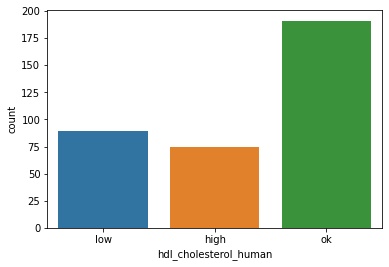

In [33]:
sns.countplot(x = all_data["hdl_cholesterol_human"]);

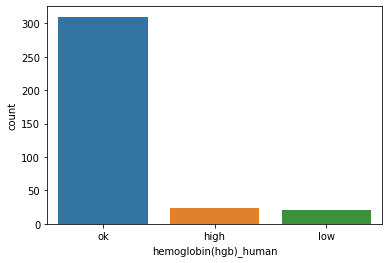

In [34]:
sns.countplot(x = all_data["hemoglobin(hgb)_human"]);

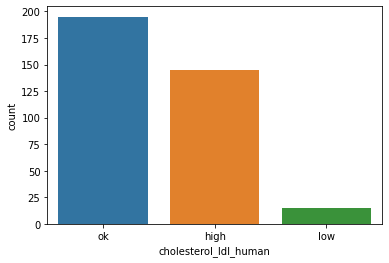

In [35]:
sns.countplot(x = all_data["cholesterol_ldl_human"]);

In [36]:
mapping = {'low' : '0', 'ok' : '1', 'high' : '2'}

reverse_mapping = {'0' : 'low', '1' : 'ok', '2' : 'high'}

all_data['hdl_cholesterol_human'] = all_data['hdl_cholesterol_human'].replace(mapping)

all_data['hemoglobin(hgb)_human'] = all_data['hemoglobin(hgb)_human'].replace(mapping)

all_data['cholesterol_ldl_human'] = all_data['cholesterol_ldl_human'].replace(mapping)

Target data is higly imbalance

In [37]:
# Split data for modelling
train = all_data[all_data['tag'] == 'train']
test = all_data[all_data['tag'] == 'test']

train = train.drop(['tag'], axis = 1)
test = test.drop(['tag'], axis = 1)

In [38]:
print(train.shape)
print(test.shape)

(355, 183)
(61, 183)


In [39]:
train.to_csv("clean_train.csv")
test.to_csv("clean_test.csv")

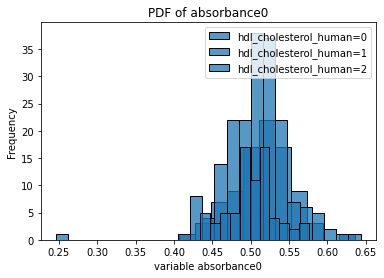

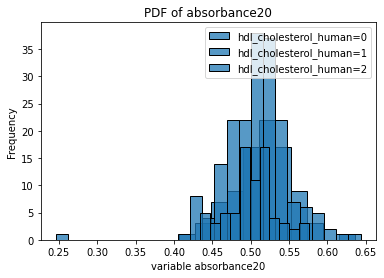

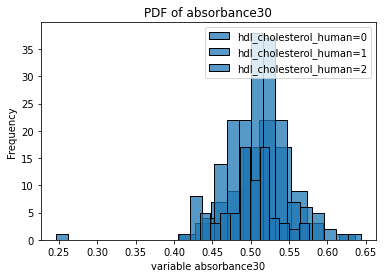

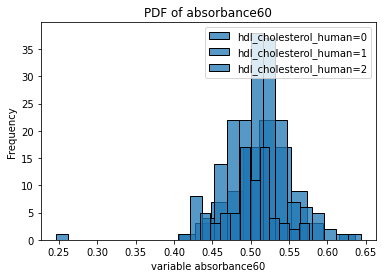

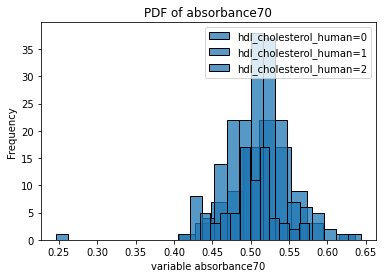

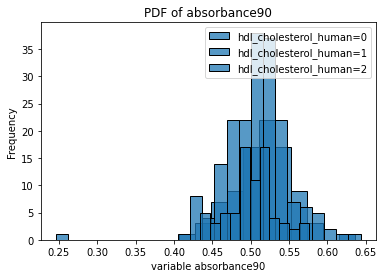

In [42]:
#Reveal some pattern about the targets
cols = ['absorbance0','absorbance20', 'absorbance30','absorbance60', 'absorbance70', 'absorbance90']
for c in cols:
    sns.histplot(train[train['hdl_cholesterol_human']=='0'][str(cols[0])], label='hdl_cholesterol_human=0');
    sns.histplot(train[train['hdl_cholesterol_human']=='1'][str(cols[0])], label='hdl_cholesterol_human=1');
    sns.histplot(train[train['hdl_cholesterol_human']=='2'][str(cols[0])], label='hdl_cholesterol_human=2');
    plt.legend(loc='upper right')
    plt.xlabel('variable {}'.format(c))
    plt.ylabel('Frequency')
    plt.title('PDF of {}'.format(c))
    plt.show()

In [41]:
train.head()

,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,...,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,std,low_abs,high_abs,med_abs,mean_abs,std_abs,sum_abs
0,1975,0.505055,0.506570,0.511544,0.516300,0.524067,0.530191,0.536138,0.542317,0.551118,...,0,1,1,0.0073,0.505055,1.927817,0.958842,1.135224,0.497048,192.988096
1,1982,0.523531,0.523485,0.526291,0.532875,0.538397,0.543180,0.547520,0.553433,0.561674,...,0,1,2,0.0043,0.523485,1.734845,0.916559,1.061186,0.421130,180.401567
2,1989,0.516449,0.519226,0.523619,0.532366,0.540438,0.547985,0.552716,0.556823,0.561827,...,0,1,2,0.0046,0.516449,1.884757,0.925547,1.087614,0.462437,184.894345
3,2018,0.514163,0.516174,0.521443,0.528857,0.534581,0.543953,0.551666,0.557929,0.565811,...,2,1,1,0.0082,0.514163,1.868637,0.942196,1.113725,0.469601,189.333202
4,2045,0.471717,0.474344,0.477808,0.483401,0.491121,0.496970,0.503694,0.509696,0.516301,...,1,1,1,0.0051,0.471717,1.917085,0.878465,1.075850,0.493414,182.894524


The target 2, 1 and 0 overlaps, this will make it harder to get a good prediction on the data set.